# Weak discriminator boosting (with box cut)

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For random number generation

from scipy.stats import norm
from scipy.stats import expon

### (1) Define generation procedure for normal and exponential distribution

In [2]:
# Normal distribution with correlation for signal

def mynorm(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,3))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*np.cos(phi) + g[1]*np.sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*np.sin(phi) + g[1]*np.cos(phi))
    
    return data

# Exponential distribution with correlation for background

def myexpo(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,3))
    
    phi = 0.5*np.arcsin(corr)

    g = np.random.normal(size=(2,Nmc))

    r1_tab = g[0]*np.cos(phi) + g[1]*np.sin(phi)
    r2_tab = g[0]*np.sin(phi) + g[1]*np.cos(phi)

# Convert correlated gaussian variables r1 & r2 
# to correlated exponential variables, based on survival function

    s1_tab = norm.sf(r1_tab)
    s2_tab = norm.sf(r2_tab)
    
    data[:,0] = pos[0] + sig[0]*expon.isf(s1_tab)
    data[:,1] = pos[1] + sig[1]*expon.isf(s2_tab)
    
    return data

### (2) Generating training and test data

In [3]:
# Sample size

Ntrain = 1000
Ntest = 1000

# Two hypothesis:

# H1: Exponential background

h1 = np.array([-1.,-1.])
sig1 = np.array([1.5,1.0])
corr1 = 0.0

# H2: Normal distribution

h2 = np.array([1.,1.])
sig2 = np.array([0.3,0.3])
corr2 = -0.7

# Fraction of first hypothesis

fh1 = 0.5

# Generate train sample 
# ---------------------

h1train = myexpo(Ntrain,h1,sig1,corr1)
h2train = mynorm(Ntrain,h2,sig2,corr2)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain > fh1

y2_train = np.resize(np.repeat(y_train,3),(Ntrain,3))

X_train = y2_train * h2train + (1 - y2_train)*h1train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = myexpo(Ntest,h1,sig1,corr1)
h2test = mynorm(Ntest,h2,sig2,corr2)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest > fh1

y2_test = np.resize(np.repeat(y_test,3),(Ntest,3))

X_test = y2_test * h2test + (1 - y2_test)*h1test

print("Test data defined, size: ",y_test.size)

# Rescale category from {0,1} to {-1,1}

y_train = 2*y_train - 1
y_test = 2*y_test - 1

Train data defined, size:  1000
Test data defined, size:  1000


### (3) Boost random classifier

In [4]:
# Number of boost steps

Nboost = 10

# Initial event weights

etab = 1.0/Ntrain * np.ones(shape=(Nboost,Ntrain))

# Boost factors

atab = np.empty(Nboost)

# Classifiers at each loop

wtab = np.zeros(shape=(Nboost,4))
 
# Results for each loop

ytab = np.empty(shape=(Nboost,Ntrain))

# Random generations in each boost step

Ntry = 10

Xmin = -0.999
Xmax = 4.999

for ib in range(Nboost):
    
    # Apply event weights starting from the second loop
    
    if ib>0:
        xcut  = (X_train[:,0] - wtab[ib-1,0])*(wtab[ib-1,1] - X_train[:,0])>0 
        ycut  = (X_train[:,1] - wtab[ib-1,2])*(wtab[ib-1,3] - X_train[:,1])>0 
        ypred  = 2.*xcut*ycut - 1.
        
        etab[ib,:] = etab[ib-1,:]*( (ypred*y_train <= 0)*(np.exp(atab[ib-1]) - 1.) + 1.)
        
        enorm = np.sum(etab[ib,:])
        etab[ib,:] /= enorm
        
        
    # Generate random weights and select best performing

    nbest = 0
    ebest = 1.0
    wbest = np.zeros(shape=4)

    for itry in range(Ntry):
        wvec = Xmin + (Xmax-Xmin)*np.random.uniform(size=4)

        xcut  = (X_train[:,0] - wvec[0])*(wvec[1] - X_train[:,0])>0
        ycut  = (X_train[:,1] - wvec[2])*(wvec[3] - X_train[:,1])>0 
        ypred  = 2.0*xcut*ycut - 1.0
        
        nok = np.sum(ypred*y_train > 0)
        
        werr = np.sum((ypred*y_train <= 0)*etab[ib,:])
        wall = np.sum(etab[ib,:])
        err = werr/wall

        if err < ebest:
            ebest = err
            wbest = wvec
            nbest = nok
            ytab[ib,:] = ypred
        
    if ebest >= 0.5:
        print("Something wrong?! Loop ",ib," error rate: ", ebest,"  classified ",nbest)
    
    # Weight for this loop
    
    wtab[ib,:] = wbest
    
    # Just in case, if perfect cut found:
    if ebest == 0: ebest = 1.0/Ntrain
    
    atab[ib] = np.log((1.0-ebest)/ebest)
     

In [5]:
# Final classifier for training sample

yall  =  atab @ ytab / Nboost 
            
ymed = np.median(yall)-0.0001

nok = np.sum((yall-ymed)*y_train > 0)

err = 1.0 - nok/Ntrain

# Apply classifier to test sample

ytab2 = np.empty(shape=(Nboost,Ntrain))

for ib in range(Nboost):
    xcut  = (X_test[:,0] - wtab[ib,0])*(wtab[ib,1] - X_test[:,0])>0 
    ycut  = (X_test[:,1] - wtab[ib,2])*(wtab[ib,3] - X_test[:,1])>0   
    ypred  = 2.0*xcut*ycut - 1.0
    ytab2[ib,:] = ypred

yall2  =  atab @ ytab2 / Nboost 
            
ymed2 = np.median(yall2)-0.0001

nok2 = np.sum((yall2-ymed2)*y_test > 0)

err2 = 1.0 - nok2/Ntest
    
# Printout

print("Combined : ",nok, " training events properly classified, error rate %.2f%%"%(100*err))
print("           ",nok2," test events properly classified,     error rate %.2f%%"%(100*err2))

Combined :  948  training events properly classified, error rate 5.20%
            963  test events properly classified,     error rate 3.70%


### (4) Plot results

In [6]:
# 2D grid for decision histogram (as background)

Xmin = -1.0
Xmax = 5.0
Nbin = 120
dX = (Xmax-Xmin)/Nbin

Xrange = np.linspace(Xmin+0.5*dX,Xmax-0.5*dX,Nbin)

X1grid, X2grid = np.meshgrid(Xrange,Xrange)

yval = np.empty(X1grid.shape)

# Loop over 2D grid
    
for i in range(Nbin):
    for j in range(Nbin):

        x1 = X1grid[i,j]  
        x2 = X2grid[i,j]      
        X = np.array([x1,x2])
        
        ysum = 0.0
        
        xcut  = (X[0] - wtab[:,0])*(wtab[:,1] - X[0])>0 
        ycut  = (X[1] - wtab[:,2])*(wtab[:,3] - X[1])>0 
        ypred  = 2.*xcut*ycut - 1.
        
        ysum = np.sum(ypred * atab)/Nboost
            
        yval[i,j]  = ysum  # 2*(ysum > ymed)-1


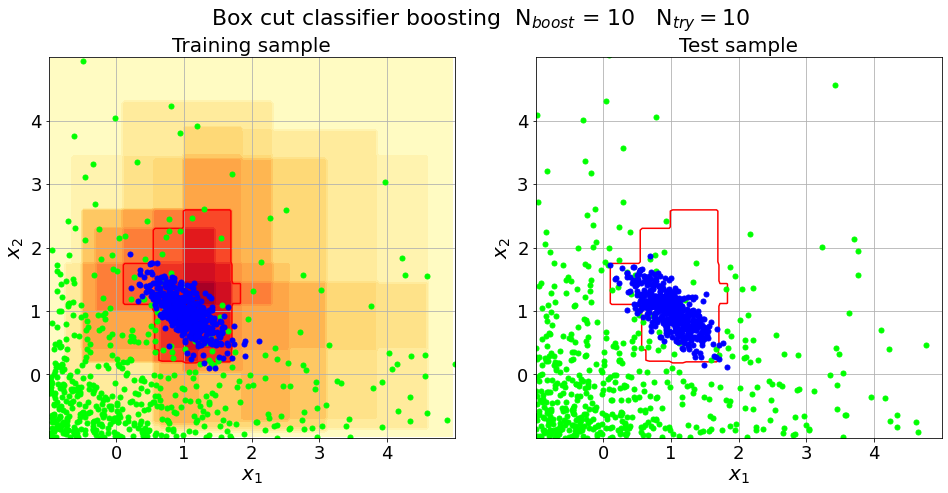

In [7]:
# Create result graph

Xmin = -0.999
Xmax = 4.999

plt.subplots(1,2,figsize=(16, 7))

plt.suptitle("Box cut classifier boosting  N$_{boost}$ = "+str(Nboost)+"   N$_{try} = $"+str(Ntry),fontsize=22)

# Train sample

plt.subplot(121)

# Decision function map

plt.contourf(X1grid,X2grid,yval,levels=20,cmap='YlOrRd')
plt.contour(X1grid,X2grid,yval,colors='red',levels=0)
    
# Training points in two categories

plt.plot(X_train[:,0][y_train==-1],X_train[:,1][y_train==-1],'o',color='lime',ms=5)
plt.plot(X_train[:,0][y_train==1],X_train[:,1][y_train==1],'o',color='blue',ms=5)

plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

plt.title("Training sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

# Test sample

plt.subplot(122)

# Decision function map

plt.contour(X1grid,X2grid,yval,colors='red',levels=0)
    
# Test points in two categories

plt.plot(X_test[:,0][y_test==-1],X_test[:,1][y_test==-1],'o',color='lime',ms=5)
plt.plot(X_test[:,0][y_test==1],X_test[:,1][y_test==1],'o',color='blue',ms=5)

plt.xlim([Xmin,Xmax])
plt.ylim([Xmin,Xmax])

plt.title("Test sample",size=20)
plt.xlabel('$x_1$',size=20)
plt.ylabel('$x_2$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '13_Cuts_'+str(Nboost)+'_'+str(Ntry)+'.png'

plt.savefig(fname)

plt.show()